In [1]:
#default_exp lesson3

In [2]:
import os
os.chdir("..")

In [3]:
# export
import torch
from torch import nn
from torch.optim import Adam
from solutions.lesson1 import *
from solutions.lesson2 import *
from fastai.datasets import download_data
from torch.functional import F
from functools import partial

In [4]:
# export
def get_mnist_data():
    """Returns X_train, y_train, X_test, y_test for MNIST dataset."""
    MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
    path = download_data(MNIST_URL, ext=".gz")
    return get_data(path) 

In [5]:
# export
def stats(x):
    return x.mean(), x.std()

In [6]:
X_train, y_train, X_test, y_test = get_mnist_data()

# Basic Model

In [7]:
x_train_resized = X_train.reshape(-1, 1, 28, 28)

In [8]:
mean, std = stats(x_train_resized)

In [9]:
x_train_resized.size()

torch.Size([50000, 1, 28, 28])

In [10]:
x_train_norm = (x_train_resized - mean)/std

In [11]:
stats(x_train_norm)

(tensor(-3.0466e-06), tensor(1.))

In [12]:
nh = 100
mdl = nn.Sequential(
    nn.Conv2d(1, 5, 5),
    nn.ReLU()
)

In [13]:
for m in mdl.modules():
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')

In [14]:
stats(mdl(x_train_norm))

(tensor(0.5755, grad_fn=<MeanBackward0>),
 tensor(1.1862, grad_fn=<StdBackward0>))

In [15]:
# export
class Lambda(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)

In [16]:
# def squeeze(x):
#     return torch.squeeze(x)

In [17]:
def conv_layer(ni, nf, size, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, size, stride, padding=size//2),
        nn.ReLU()
    )

In [18]:
mdl = nn.Sequential(
    conv_layer(1, 8, 5),
    conv_layer(8, 16, 3),
    conv_layer(16, 32, 3),
    conv_layer(32, 64, 3),
    conv_layer(64, 64, 3),
    conv_layer(64, 10, 3),
    nn.AdaptiveAvgPool2d(1),
    nn.LogSoftmax(dim=1),
    Lambda(torch.squeeze)
)

In [19]:
mdl(x_train_norm).size()

torch.Size([50000, 10])

In [20]:
mdl(x_train_norm).squeeze().size()

torch.Size([50000, 10])

In [21]:
x_valid_norm = X_test.reshape(-1, 1, 28, 28)
x_valid_norm = (x_valid_norm - mean)/std

In [22]:
stats(x_valid_norm)

(tensor(-0.0059), tensor(0.9924))

In [23]:
train_data = Dataset(x_train_norm, y_train)
valid_data = Dataset(x_valid_norm, y_test)

In [24]:
c = (torch.max(y_test) + 1).item()

In [25]:
train_dl = DataLoader(train_data, 512)
valid_dl = DataLoader(valid_data, 1024)
data = DataBunch(train_dl, valid_dl, c=c)

In [26]:
data.c

10

In [27]:
g = nn.Conv2d(8, 16, 3)

In [28]:
# export
class GeneralReLU(nn.Module):
    def __init__(self, a=0.01, subtract=0.4):
        super().__init__()
        self.a = a
        self.subtract = subtract
        
    def forward(self, x):
        return F.leaky_relu(x, self.a) - self.subtract

In [29]:
def init_cnn_(mdl):
    for layer in mdl.children():
        if isinstance(layer, nn.Conv2d):
            print("initializing conv2d...")
            nn.init.kaiming_normal_(layer.weight)
            if hasattr(layer, 'bias'):
                nn.init.zeros_(layer.bias)
        if isinstance(layer, nn.Sequential): init_cnn_(layer)
            
def conv_layer(ni, nf, size, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, size, stride, padding=size//2),
        GeneralReLU(**kwargs)
    )
    
def get_model():
    conv_layers = [ 
        conv_layer(1, 8, 5),
        conv_layer(8, 16, 3),
        conv_layer(16, 32, 3),
        conv_layer(32, 64, 3),
        conv_layer(64, 10, 3),
    ]
             
    mdl = nn.Sequential(
        *conv_layers,
        nn.AdaptiveAvgPool2d(1),
        nn.LogSoftmax(dim=1),
        Lambda(torch.squeeze)
    ) 
    
    init_cnn_(mdl)
    
    return mdl 

In [30]:
mdl = get_model()

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [31]:
mdl

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LogSoftmax()
  (7): Lambda()
)

In [32]:
opt = Adam(mdl.parameters(), lr=1e-3)
loss = F.cross_entropy
learn = Learn(mdl, opt, data, loss)
runner = Runner(learn)

In [33]:
nn.NLLLoss()(F.log_softmax(torch.tensor([[1,2,3]]).float()), torch.tensor([2]))

/home/paperspace/.pyenv/versions/miniconda3-3.7.0/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(0.4076)

In [34]:
# %time runner.fit(epochs=1)

# Some useful callbacks

In [35]:
torch.cuda.current_device()

0

In [36]:
torch.cuda.is_available()

True

In [37]:
# export
def current_gpu():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [38]:
# export
class AverageStatsCallback(Callback):
    def __init__(self, f, name):
        self.f = f
        self.name = name
        
    def on_epoch_start(self):
        self.value = 0.
        self.count = 0
        
    def on_batch_end(self):
        if runner.mode == ModelMode.VALID:
            batch_count = self.runner.xb.size()[0]
            self.count += batch_count
            self.value += self.f(self.runner.pred, self.runner.yb) * batch_count
            
    def on_epoch_end(self):
        if runner.mode == ModelMode.VALID:
            print("{} after epoch {}: {}".format(self.name, self.runner.epochs, self.value/self.count))

In [39]:
# export 
def accuracy(preds, actuals):
    return (torch.argmax(preds, axis=1) == actuals).float().sum()/(preds.size()[0])

In [40]:
test_pred = torch.tensor([[0.1, 0.5, 0.3]])
test_actual = torch.tensor([1])
assert accuracy(test_pred, test_actual) == 1.

test_pred_2 = torch.tensor([[0.1, 0.5, 0.3], [0.9, 0.8, 0.7]])
test_actual_2 = torch.tensor([1, 2])
assert accuracy(test_pred_2, test_actual_2) == 0.5

In [41]:
AccuracyCallback = AverageStatsCallback(accuracy, "accuracy")

In [42]:
stats(data.train_dl.ds.x)

(tensor(-3.0466e-06), tensor(1.))

In [43]:
stats(data.valid_dl.ds.x)

(tensor(-0.0059), tensor(0.9924))

In [44]:
mdl = get_model()
opt = Adam(mdl.parameters(), lr=1e-3)
loss = F.cross_entropy
learn = Learn(mdl, opt, data, loss)
runner = Runner(learn)

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [45]:
scheduler = CombinedScheduler([0.3, 0.7], CosineScheduler(1e-3, 1e-2, 'lr'), CosineScheduler(1e-2, 1e-5, 'lr'))
runner = Runner(learn, cb_funcs=[AccuracyCallback, scheduler])

In [46]:
runner.fit(epochs=2)

accuracy after epoch 0: 0.9690999984741211
Validation loss: 0.1025
accuracy after epoch 1: 0.9811000227928162
Validation loss: 0.0845


# Convenience Method for Generating a Model

In [48]:
def get_runner(lr, loss, data, cbs): 
    mdl = get_model()
    opt = Adam(mdl.parameters(), lr=lr)
    learn = Learn(mdl, opt, data, loss)
    return Runner(learn, cb_funcs=cbs)

# Hooks

In [49]:
class Hook:
    def __init__(self, f, m):
        self.f = f 
        self.m = m
        self.hook = m.register_forward_hook(f)
        
    def remove(self):
        self.hook.remove() 
            
    def __del__(self): self.remove()
        
    def __repr__(self): return "Hook(" + self.f.__name__ + ")" 

In [50]:
class ListContainer:
    def __init__(self, *items):
        self.items = list(items)
        
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.items[idx]
        
        if isinstance(idx, list):
            if len(idx) == 0:
                return []
            
            if isinstance(idx[0], int):
                return [self.items[i] for i in idx]
            
            if isinstance(idx[0], bool) and len(idx) == len(self.items):
                return [self.items[i] for i in range(len(self.items)) if idx[i]] 
            
        raise ValueError("idx must be an integer, list of integers, or list of bools.")
        
    def __setitem__(self, idx, item):
        self.items[idx] = item
        
    def __iter__(self): return iter(self.items)
    
    def __repr__(self):
        if len(self.items) <= 10:
            return str(self.items)
        else:
            strs = [str(i) for i in self.items[:10]]
            strs.append("...")
            return str(strs).replace("\'", "") 
        
    def __str__(self): return self.__repr__()

In [51]:
class Hooks(ListContainer):
    def __init__(self, *hooks):
        self.hooks = list(hooks)
            
    def remove(self):
        for hook in self.hooks: hook.remove()
            
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.remove()
        
    def __del__(self):
        self.remove()

In [52]:
mdl

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LogSoftmax()
  (7): Lambda()
)

In [53]:
list(mdl.children())

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), AdaptiveAvgPool2d(output_size=1), LogSoftmax(), Lambda()]

In [54]:
[i for i in mdl.modules()]

[Sequential(
   (0): Sequential(
     (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
     (1): GeneralReLU()
   )
   (1): Sequential(
     (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (2): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (3): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (4): Sequential(
     (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (5): AdaptiveAvgPool2d(output_size=1)
   (6): LogSoftmax()
   (7): Lambda()
 ), Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): GeneralReLU()
 ), Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), GeneralReLU(), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1):

In [55]:
class LayerStatsCallback(Callback):
    
    __name__ = "layer_stats"
    
    def on_train_start(self):
        self.means = [[] for _ in self.runner.learn.model]
        self.sds = [[] for _ in self.runner.learn.model]          
        self.hooks = Hooks(
            *[Hook(partial(LayerStatsCallback.append_stats, self.means[idx], self.sds[idx]), layer) 
              for idx, layer in enumerate(self.runner.learn.model)]
        )  
        
    @staticmethod
    def append_stats(mean_list, sd_list, m, i, o):
        mean_list.append(o.mean())
        sd_list.append(o.std()) 

In [56]:
# Next steps:
# - write a hook that stores the stats of some given activations after each call to `forward`
# - plot those stats across iterations for each layer

In [57]:
lsc = LayerStatsCallback()

In [58]:
runner = get_runner(1e-3, F.cross_entropy, data, [AverageStatsCallback(accuracy, "accuracy"), scheduler, lsc])

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [59]:
# hooks = [Hook(LayerStats(), m) for m in list(runner.learn.model.children())[:5]]

In [60]:
# hooks

In [60]:
runner.fit(10)

accuracy after epoch 0: 0.9467999935150146
Validation loss: 0.1777
accuracy after epoch 1: 0.9729999899864197
Validation loss: 0.1338
accuracy after epoch 2: 0.979200005531311
Validation loss: 0.1127
accuracy after epoch 3: 0.980400025844574
Validation loss: 0.1015
accuracy after epoch 4: 0.9818999767303467
Validation loss: 0.0940
accuracy after epoch 5: 0.9835000038146973
Validation loss: 0.0884
accuracy after epoch 6: 0.9861999750137329
Validation loss: 0.0834
accuracy after epoch 7: 0.9869999885559082
Validation loss: 0.0787
accuracy after epoch 8: 0.9876999855041504
Validation loss: 0.0750
accuracy after epoch 9: 0.9878000020980835
Validation loss: 0.0721


In [61]:
import pandas as pd

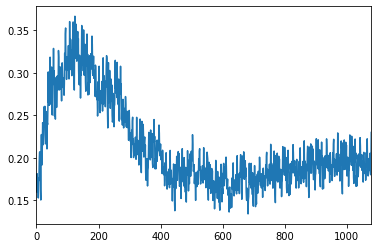

In [62]:
pd.Series([i.item() for i in runner.cbs[2].means[0]]).plot()

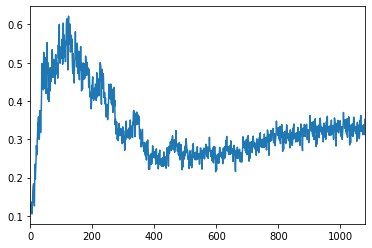

In [63]:
pd.Series([i.item() for i in runner.cbs[2].means[1]]).plot()

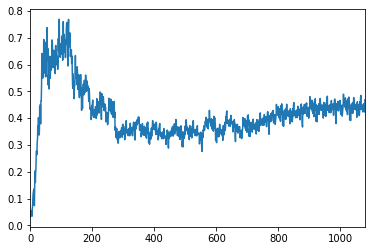

In [64]:
pd.Series([i.item() for i in runner.cbs[2].means[2]]).plot()

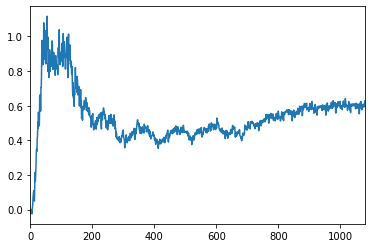

In [65]:
pd.Series([i.item() for i in runner.cbs[2].means[3]]).plot()

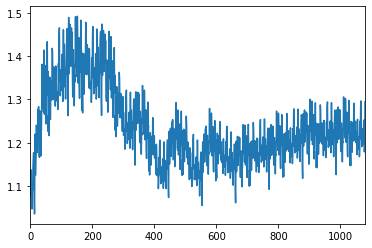

In [66]:
pd.Series([i.item() for i in runner.cbs[2].sds[0]]).plot()

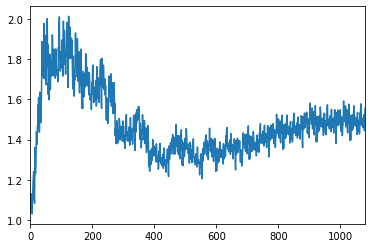

In [67]:
pd.Series([i.item() for i in runner.cbs[2].sds[1]]).plot()

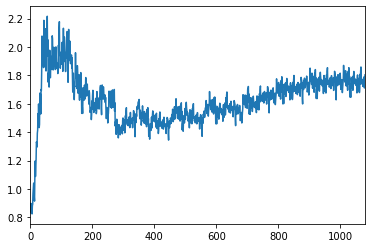

In [68]:
pd.Series([i.item() for i in runner.cbs[2].sds[2]]).plot()

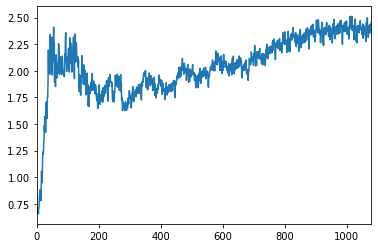

In [69]:
pd.Series([i.item() for i in runner.cbs[2].sds[3]]).plot()

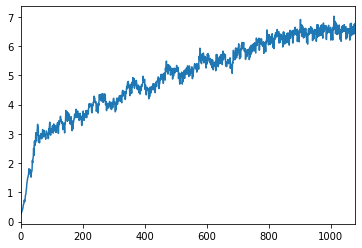

In [70]:
pd.Series([i.item() for i in runner.cbs[2].sds[4]]).plot()

In [71]:
runner.learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LogSoftmax()
  (7): Lambda()
)

# Implement Batch Norm

In [67]:
torch.randn(3,4,5,6).mean(dim=(0,2,3), keepdim=True).size()

torch.Size([1, 4, 1, 1])

In [74]:
# export 
class BatchNorm(nn.Module):
    def __init__(self, nf, eps=1e-5, mom=0.1):
        super().__init__()
        self.eps = eps
        self.mom = mom
        self.gamma = nn.Parameter(torch.ones(nf, 1, 1))
        self.beta = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('mean', torch.zeros(1, nf, 1, 1))
        self.register_buffer('var', torch.ones(1, nf, 1, 1))
        
    def update_stats(self, x):
        mean, var = x.mean(dim=(0,2,3), keepdim=True), x.var(dim=(0,2,3), keepdim=True)
        self.mean.lerp_(mean, self.mom)
        self.var.lerp_(var, self.mom)
        return self.mean, self.var
        
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)  
        else:
            m, v = self.mean, self.var
            
        x_hat = (x - m) / (v + self.eps).sqrt()
        return self.gamma * x_hat + self.beta

In [75]:
# export
def init_cnn_(mdl):
    for layer in mdl.children():
        if isinstance(layer, nn.Conv2d):
            print("initializing conv2d...")
            nn.init.kaiming_normal_(layer.weight)
            if hasattr(layer, 'bias'):
                nn.init.zeros_(layer.bias)
        if isinstance(layer, nn.Sequential): init_cnn_(layer)
            
def conv_layer(ni, nf, size, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, size, stride, padding=size//2),
        GeneralReLU(**kwargs) 
    ]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)
    
def get_model():
    conv_layers = [ 
        conv_layer(1, 8, 5),
        conv_layer(8, 16, 3),
        conv_layer(16, 32, 3),
        conv_layer(32, 64, 3),
        conv_layer(64, 10, 3),
    ]
             
    mdl = nn.Sequential(
        *conv_layers,
        nn.AdaptiveAvgPool2d(1),
        nn.LogSoftmax(dim=1),
        Lambda(torch.squeeze)
    ) 
    
    init_cnn_(mdl)
    
    return mdl 

In [76]:
# export
def get_runner(lr, loss, data, cbs): 
    mdl = get_model()
    opt = Adam(mdl.parameters(), lr=lr)
    learn = Learn(mdl, opt, data, loss)
    return Runner(learn, cb_funcs=cbs)

In [95]:
scheduler = CombinedScheduler([0.3, 0.7], CosineScheduler(1e-3, 1, 'lr'), CosineScheduler(1, 1e-3, 'lr'))

In [96]:
runner = get_runner(1e-3, F.cross_entropy, data, [AverageStatsCallback(accuracy, "accuracy"), scheduler])

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [97]:
# runner.learn.model

In [98]:
runner.fit(10)

accuracy after epoch 0: 0.9567000269889832
Validation loss: 0.1485
accuracy after epoch 1: 0.968999981880188
Validation loss: 0.1276
accuracy after epoch 2: 0.9796000123023987
Validation loss: 0.1087
accuracy after epoch 3: 0.9825000166893005
Validation loss: 0.0963
accuracy after epoch 4: 0.9842000007629395
Validation loss: 0.0876
accuracy after epoch 5: 0.9854999780654907
Validation loss: 0.0817
accuracy after epoch 6: 0.9879000186920166
Validation loss: 0.0772
accuracy after epoch 7: 0.9890999794006348
Validation loss: 0.0727
accuracy after epoch 8: 0.9901000261306763
Validation loss: 0.0686
accuracy after epoch 9: 0.9900000095367432
Validation loss: 0.0655
